## 0. Import libraries

In [32]:
import torch
import pandas as pd
import numpy as np
import math, copy, time
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset 
from torch.optim import Adam
import tqdm
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

## 1. Load Data

In [33]:
df = pd.read_csv('./total.csv')
df.tail()

,Date,S&P,currency,gold,kospi,kospi_shift
5339,2024-05-17,5303.270020,1346.040039,2412.199951,2724.620117,2742.139893
5340,2024-05-20,5308.129883,1353.390015,2433.899902,2742.139893,2724.179932
5341,2024-05-21,5321.410156,1360.160034,2421.699951,2724.179932,2723.459961
5342,2024-05-22,5307.009766,1363.420044,2389.199951,2723.459961,2721.810059
5343,2024-05-23,5307.009766,1363.420044,2365.199951,2721.810059,2721.810059


In [34]:
col_names = df.columns.values
print(col_names)

['Date' 'S&P' 'currency' 'gold' 'kospi' 'kospi_shift']


In [35]:
# global variables and hyperparameter
IN_DIM = 128
DAY_INT = 1
BATCH_SIZE = 64
SCALER = 'MINMAX'   # 'NORMAL'
# SCALER = 'NORMAL'   # 'NORMAL'
TRAIN_TEST_SPLIT = 0.95
ENCODING = 'Conv1d'

## 2. Split data train and test

In [36]:
# train test split
df_train = df.iloc[:int(len(df) * TRAIN_TEST_SPLIT), :]
df_test = df.iloc[int(len(df) * TRAIN_TEST_SPLIT): , :]
# print(df_train.tail())
# print(df_test.head())
print(col_names)

scale_params = pd.DataFrame(index=['mean', 'var', 'max', 'min'])
# print(scale_params)
for i in col_names[1:]:
    print(df_train[i])
    scale_params[i] = [df_train[i].mean(), df_train[i].var(), df_train[i].max(), df_train[i].min()]
scale_params

['Date' 'S&P' 'currency' 'gold' 'kospi' 'kospi_shift']
0       1070.119995
1       1066.619995
2       1064.729980
3       1069.719971
4       1061.500000
           ...     
5071    4119.169922
5072    4137.640137
5073    4130.620117
5074    4124.080078
5075    4136.279785
Name: S&P, Length: 5076, dtype: float64
0       1198.400024
1       1195.000000
2       1192.500000
3       1190.099976
4       1184.699951
           ...     
5071    1322.410034
5072    1326.050049
5073    1318.050049
5074    1329.880005
5075    1341.520020
Name: currency, Length: 5076, dtype: float64
0        402.700012
1        403.700012
2        403.899994
3        403.299988
4        406.399994
           ...     
5071    2036.199951
5072    2030.500000
5073    2014.699951
5074    2014.500000
5075    2018.000000
Name: gold, Length: 5076, dtype: float64
0        807.390015
1        807.780029
2        808.340027
3        805.130005
4        789.409973
           ...     
5071    2510.060059
5072    2496.510010

,S&P,currency,gold,kospi,kospi_shift
mean,2.060187e+03,1120.468225,1212.153132,1908.118825,1908.346142
var,1.040263e+06,11179.495861,197490.747079,285130.964445,285101.043571
max,4.796560e+03,1571.400024,2051.500000,3305.209961,3305.209961
min,6.765300e+02,886.679993,374.799988,719.590027,719.590027


In [37]:
# scaling
train_data = pd.DataFrame()
test_data = pd.DataFrame()
if SCALER == 'MINMAX':
    for i in col_names[1:]:
        train_data[i] = df_train[i].apply(lambda x: (x - scale_params.loc['min', i])/(scale_params.loc['max', i] - scale_params.loc['min', i]))
        test_data[i] = df_test[i].apply(lambda x: (x - scale_params.loc['min', i])/(scale_params.loc['max', i] - scale_params.loc['min', i]))
elif SCALER == 'NORMAL':
    for i in col_names[1:]:
        train_data[i] = df_train[i].apply(lambda x: (x - scale_params.loc['mean', i])/scale_params.loc['var', i])
        test_data[i] = df_test[i].apply(lambda x: (x - scale_params.loc['mean', i])/scale_params.loc['var', i])
test_data.tail()

,S&P,currency,gold,kospi,kospi_shift
5339,1.122987,0.670873,1.215125,0.775454,0.782230
5340,1.124167,0.681607,1.228067,0.782230,0.775284
5341,1.127390,0.691494,1.220791,0.775284,0.775006
5342,1.123895,0.696255,1.201407,0.775006,0.774367
5343,1.123895,0.696255,1.187094,0.774367,0.774367


In [38]:
class StockDataset(Dataset):
    def __init__(self, data, input_window=128, output_window=1, stride=1):
        #총 데이터의 개수
        # print(data.shape)
        L = data.shape[0]
        features = data.shape[1] - 1
        #stride씩 움직일 때 생기는 총 sample의 개수
        num_samples = (L - input_window - output_window) // stride + 1
        start_pos = (L - input_window - output_window) % stride
        iter_times = (L - input_window - output_window) // stride + 1
        # print(data.shape, num_samples, iter_times, start_pos, L)

        #input과 output
        X = np.zeros([num_samples, input_window, features])
        Y = np.zeros([num_samples, output_window])
        # print(X.shape, Y.shape)
        for i in np.arange(num_samples):
            start_x = start_pos + i * stride
            end_x = start_x + input_window
            X[i, :, :] = data.iloc[start_x:end_x, :-1]

            # end_y = start_y + output_window
            # print(i, start_x, end_x)
            Y[i, :] = data.iloc[end_x: end_x + output_window, -1:]
        # print(X.shape, Y.shape)
        # X = X.reshape(X.shape[0], X.shape[1], 1).transpose((1,0,2))
        # Y = Y.reshape(Y.shape[0], Y.shape[1], 1).transpose((1,0,2))
        print(X.shape, Y.shape)
        self.x = X
        self.y = Y
        
        self.len = len(X)
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    def __len__(self):
        return self.len

In [39]:
print(train_data.iloc[0:3, :])
train_dataset = StockDataset(train_data, 128, 1, 1)
# (5072, 5)

        S&P  currency      gold     kospi  kospi_shift
0  0.095531  0.455252  0.016640  0.033957     0.034108
1  0.094681  0.450286  0.017236  0.034108     0.034324
2  0.094223  0.446635  0.017356  0.034324     0.033083
(4948, 128, 4) (4948, 1)


### 3. create dataloader

In [40]:
train_dataset = StockDataset(train_data, 128, 1, 1)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = StockDataset(test_data, 128, 1, 1)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
a1 = next(iter(train_dataset))
print(len(train_dataloader), len(train_dataloader.dataset), a1[0].shape, a1[1].shape)
# print(a1)

(4948, 128, 4) (4948, 1)
(140, 128, 4) (140, 1)
78 4948 (128, 4) (1,)


## 4. Make a Transformer model

In this sections, we will implement the building blocks of the transformer: [Positional encoding](#1a), [Multi-head attention](#1b) and [Position wise feedforward network](#1c)

### a. Sinusoidal Positional Encoding
<a id='1a'></a>
In this section, we will implement sinusoidal positional encoding

$$\begin{align}
PE(pos, 2i) &= \sin \left( pos / 10000^{2i / d_{model}} \right)  \\
PE(pos, 2i+1) &= \cos \left( pos / 10000^{2i / d_{model}} \right)  
\end{align}$$

In [41]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model , max_len, device):
        """
        d_model: dimension of model
        max_len: maximum sequence length
        device: 'cuda' or 'cpu'
        """
        super().__init__()
        self.encoding = torch.zeros(max_len, d_model, device=device)
        self.encoding.required_grad = False

        pos = torch.arange(0, max_len, device=device)
        pos = pos.float().unsqueeze(dim=1) # [a, b, ...] -> [[a], [b], [c], ...]

        _2i = torch.arange(0, d_model, step=2, device=device) # i is d_model and step=2 means 2*i
        self.encoding[:, 0::2] = torch.sin(pos / (10000 ** (_2i / d_model)))
        self.encoding[:, 1::2] = torch.cos(pos / (10000 ** (_2i / d_model)))
    
    def forward(self, x):
        # x: Tensor, shape ``[batch_size, seq_len, embedding_dim]
        # d_model = 512
        # print(x.size())
        batch_size, seq_len = x.size()[:2]
        pe = self.encoding[:seq_len, :]
        return pe

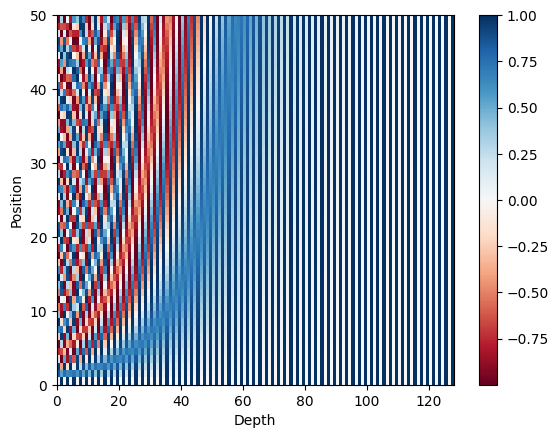

In [42]:
sample_pos_encoding = PositionalEncoding(128, 50, device='cpu')

plt.pcolormesh(sample_pos_encoding.encoding.numpy(), cmap='RdBu')
plt.xlabel('Depth')
plt.ylabel('Position')
plt.colorbar()
plt.show()


### b. Scaled dot product attention

__Scaled dot product:__
![picture](./assets/transformer_2.png)

In [43]:
class ScaleDotProductAttention(nn.Module):
    """
    Query: given setence
    Key: same with query(encoder)
    Value: same with key
    """

    def __init__(self):
        super().__init__()
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, q, k, v, mask=None, e=1e-12):
        # input: 4 dimension tensor
        # [batch_size, head, length, d_tensor]
        batch_size, head, length, d_tensor = k.size()

        # 1. q @ K.T
        k_t = k.transpose(2, 3)
        score = (q @ k_t) / math.sqrt(d_tensor)

        # 2. masking(decoder self attention only)
        if mask is not None:
            score = score.masked_fill(mask == 0, -10000)
        
        # 3. pass them softmax to [0, 1] range
        score = self.softmax(score)

        # 4. multiply with value
        v = score @ v

        return v, score

### c. MultiheadAttention
<a id='1b'></a>
Equation:

$$\begin{align} \text{MultiHead}(Q, K, V) &= \text{Concat}(head_1, ...., head_h) W^O \\
\text{where head}_i &= \text{Attention} \left( QW^Q_i, K W^K_i, VW^v_i \right)
\end{align}$$

In [44]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_head):
        super().__init__()
        self.n_head = n_head
        self.attention = ScaleDotProductAttention()
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_concat = nn.Linear(d_model, d_model)
    
    def forward(self, q, k, v, mask=None):
        # 1. dot product with weight matrices
        q, k, v = self.w_q(q), self.w_k(k), self.w_v(v)

        # 2. split tensor by heads
        q, k, v = self.split(q), self.split(k), self.split(v)

        # 3. scale dot product
        out, attention = self.attention(q, k, v, mask=mask)

        # 4. concat and pass to linear layer
        out = self.concat(out)
        out = self.w_concat(out)

        return out
    
    def split(self, tensor):
        '''
        split tensor by heads
        tensor: [batch_size, seq_len, d_model]
        return: [batch_size, head, seq_len, d_tensor] --- d_model = head * d_tensor
        '''
        batch_size, seq_len, d_model = tensor.size()
        d_tensor = d_model // self.n_head
        tensor = tensor.view(batch_size, seq_len, self.n_head, d_tensor).transpose(1, 2)
        # split by # of heads
        return tensor
    
    def concat(self, tensor):
        '''
        inverse of split(tensor)
        tensor: [batch_size, head, seq_len, d_tensor]
        return: [batch_size, seq_len, d_model]
        '''
        batch_size, head, seq_len, d_tensor = tensor.size()
        d_model = head * d_tensor

        tensor = tensor.transpose(1, 2).contiguous().view(batch_size, seq_len, d_model)
        return tensor
        

### d. Position-wise feed forward network
<a id='1c'></a>
In this section, we will implement position-wise feed forward network

$$\text{FFN}(x) = \max \left(0, x W_1 + b_1 \right) W_2 + b_2$$

In [45]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, hidden, dropout):
        super().__init__()
        self.linear1 = nn.Linear(d_model, hidden)
        self.linear2 = nn.Linear(hidden, d_model)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)
    
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x

### e. Layer Normalization

In [46]:
class LayerNorm(nn.Module):
    def __init__(self, d_model, eps=1e-12):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(d_model))
        self.beta = nn.Parameter(torch.zeros(d_model))
        self.eps = eps
    
    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        var = x.var(-1, keepdim=True)
        # -1 to get mean and var for the last dimension(d_model)

        out = (x - mean) / torch.sqrt(var + self.eps)
        out = self.gamma * out + self.beta
        return out

## 5. Embedding input data

make 1 input dimension data to d_model dimentions

In [47]:
class LinearEmbedding(nn.Module):
    def __init__(self, dropout, d_model):
        '''
        data: [batch_size, seq_len, 1]
        In this model, only kospi input window
        '''
        super().__init__()
        self.d_model = d_model
        self.linear1 = nn.Linear(1, d_model//2)
        self.linear2 = nn.Linear(d_model//2, d_model)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)
        # self.normal = LayerNorm(d_model=d_model)
    
    def forward(self, x):
        '''
        input: [batch_size, seq_len, 4]
        output: [batch_size, seq_len, 4, d_model]
        '''
        batch_size, sel_len, x_len = x.size()
        x = x.unsqueeze(-1)
        # cls_token = torch.rand((x.size()[0], x.size()[1], 1, x.size()[-1]), device=x.device)
        # print(cls_token.size(), x.size())
        # print(x[0, 0, :, :])
        # x = torch.concat([x, cls_token], dim=2) # add CLS token for attention. pos [ , , , -1]
        # print(x.size())
        # print(x[0, 0, :, :])
        # residual = x
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        # x = self.normal(x)
        x = self.linear2(x)
        x = self.relu(x)
        return x


In [48]:
class Conv1dEncoding(nn.Module):
    def __init__(self, in_ch, model_d):
        super().__init__()
        self.conv1d_1 = nn.Conv1d(in_channels=in_ch, out_channels=model_d//2, kernel_size=3, padding=1)
        self.conv1d_2 = nn.Conv1d(in_channels=model_d//2, out_channels=model_d//2, kernel_size=3, padding=1)
        self.conv1d_3 = nn.Conv1d(in_channels=model_d//2, out_channels=model_d, kernel_size=3, padding=1)

    def forward(self, x):
        # print('start:', x.size())
        x = x.transpose(1, 2).contiguous()
        # print('transpose:', x.size())
        x = self.conv1d_1(x)
        x = self.conv1d_2(x)
        x = self.conv1d_3(x)
        x = x.transpose(1, 2).contiguous()
        # print('end:', x.size())
        return x
        

In [49]:
class EmbeddingAttention(nn.Module):
    def __init__(self, model_d):
        super().__init__()
        self.w_q = nn.Linear(model_d, model_d)
        self.w_k = nn.Linear(model_d, model_d)
        self.w_v = nn.Linear(model_d, model_d)
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, q, k, v, mask=None, e=1e-12):
        # q: 4 dimension tensor
        # [batch_size, seq_len, length, model_d] q length is 1 and k, v length is 4
        batch_size, seq_len, length, model_d = k.size()
        q, k, v = self.w_q(q), self.w_k(k), self.w_v(v)

        # 1. q @ K.T
        k_t = k.transpose(2, 3)
        # print('q_size:', q.size(), ' , k_t_size:', k_t.size())
        score = (q @ k_t) / math.sqrt(model_d)

        # 2. masking(decoder self attention only)
        if mask is not None:
            score = score.masked_fill(mask == 0, -10000)
        
        # 3. pass them softmax to [0, 1] range
        score = self.softmax(score)

        # 4. multiply with value
        v = score @ v

        return v, score

In [50]:
class TrnasformerEmbedding(nn.Module):
    '''
    d_model: dimension of input data
    seq_len: max length of sequence
    '''
    def __init__(self, in_ch, dropout, d_model, seq_len, device):
        super().__init__()
        self.lin_emb = LinearEmbedding(dropout, d_model)
        self.cnn = Conv1dEncoding(in_ch, d_model)
        self.emb_attn = EmbeddingAttention(d_model)
        self.pos_emb = PositionalEncoding(d_model, seq_len, device)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        if ENCODING == 'Conv1d':
            out = self.cnn(x)
        else :
            lin_emb = self.lin_emb(x)
            attn_emb, score = self.emb_attn(lin_emb[:, :, -1, :].unsqueeze(2), lin_emb[:, :, :-1, :], lin_emb[:, :, :-1, :])
            out = attn_emb.squeeze(2)
        pos_emb = self.pos_emb(x)
        # print('attn_emb:', attn_emb.size())
        # print('pos_emb:', pos_emb.size())
        return self.dropout(out + pos_emb)

## 6. Encoder Layer
Trnasformer Encoder Except Embedding

In [51]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, ffn_hidden, n_head, dropout):
        super().__init__()
        self.attention = MultiHeadAttention(d_model=d_model, n_head=n_head)
        self.normal1 = LayerNorm(d_model=d_model)
        self.dropout1 = nn.Dropout(p=dropout)

        self.ffn = PositionwiseFeedForward(d_model=d_model, hidden=ffn_hidden, dropout=dropout)
        self.normal2 = LayerNorm(d_model=d_model)
        self.dropout2 = nn.Dropout(p=dropout)
    
    def forward(self, x, src_mask=None):
        # 1. multihead Attention
        residual = x
        x = self.attention(x, x, x)

        # 2. add and norm
        x = self.dropout1(x)
        x = self.normal1(x + residual)

        # 3. positionwise FFN
        residual = x
        x = self.ffn(x)

        # 4. add and norm
        x = self.dropout2(x)
        x = self.normal2(x + residual)

        return x

## 7. Encoder
Build Embedding and Encoder Block

In [52]:
class Encoder(nn.Module):
    def __init__(self, in_ch, seq_len, d_model, ffn_hidden, n_head, dropout, n_layers, device):
        super().__init__()
        self.emb = TrnasformerEmbedding(in_ch, dropout, d_model, seq_len, device)
        self.layers = nn.ModuleList([EncoderLayer(d_model, ffn_hidden, n_head, dropout)
                                     for _ in range(n_layers)])
    
    def forward(self, x):
        x = self.emb(x)
        for layer in self.layers:
            x = layer(x)
        
        return x

## 8. Transformer Encoder
Only use encoder module and FFN 

In [53]:
class TransformerEncoder(nn.Module):
    def __init__(self, in_ch, seq_len, d_model, ffn_hidden, n_head, dropout, n_layers, device):
        super().__init__()
        self.encoder = Encoder(in_ch, seq_len, d_model, ffn_hidden, n_head, dropout, n_layers, device)
        self.flatten = nn.Flatten()
        self.flatten_dim = seq_len * d_model
        self.linear1 = nn.Linear(self.flatten_dim, self.flatten_dim // 100)
        self.linear2 = nn.Linear(self.flatten_dim // 100, self.flatten_dim // 1000)
        self.linear3 = nn.Linear(self.flatten_dim // 1000, 1)

        self.dropout = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.flatten(x)
        # print(x.size())
        # x = self.linear1(x)[:, -1, :]
        x = self.linear1(x)
        # print(x.size())
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear3(x)
        x = self.relu(x)
        return x

## 9. model, loss_fn, optimizer


In [54]:
# next(iter(train_dataloader)).shape
# torch.cuda.empty.cache()
batch_size, seq_len, input_dim = next(iter(train_dataloader))[0].size()
print(batch_size, seq_len, input_dim)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_d = 256
in_ch = 4
dropout = 0.2
ffn_hidden = model_d // 2
n_layers = 4
n_head = 4
lr = 1e-4
lr_sched = True

64 128 4


In [55]:
model = TransformerEncoder(in_ch, seq_len, model_d, ffn_hidden, n_head, dropout, n_layers, device).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr )
if lr_sched == True:
    # scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer,
    #                                     lr_lambda=lambda epoch: 0.95 ** epoch,
    #                                     last_epoch=-1,
    #                                     verbose=False)
    # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

In [56]:
model

TransformerEncoder(
  (encoder): Encoder(
    (emb): TrnasformerEmbedding(
      (lin_emb): LinearEmbedding(
        (linear1): Linear(in_features=1, out_features=128, bias=True)
        (linear2): Linear(in_features=128, out_features=256, bias=True)
        (relu): ReLU()
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (cnn): Conv1dEncoding(
        (conv1d_1): Conv1d(4, 128, kernel_size=(3,), stride=(1,), padding=(1,))
        (conv1d_2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
        (conv1d_3): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
      )
      (emb_attn): EmbeddingAttention(
        (w_q): Linear(in_features=256, out_features=256, bias=True)
        (w_k): Linear(in_features=256, out_features=256, bias=True)
        (w_v): Linear(in_features=256, out_features=256, bias=True)
        (softmax): Softmax(dim=-1)
      )
      (pos_emb): PositionalEncoding()
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (layers)

## 10. Train and Test function

In [57]:
linear_model = LinearEmbedding(0.2, model_d).to(device)
in_x, in_y = next(iter(train_dataloader))
in_x = in_x.to(device).float()
out = linear_model(in_x)
out.size()
print(in_x.size())
print(out.size())

torch.Size([64, 128, 4])
torch.Size([64, 128, 4, 256])


In [58]:
a = torch.rand((64, 128, 1, 1024))
b = torch.rand((64, 128, 1024, 4))
c = a @ b
print(a[:, :, -1, :].unsqueeze(2).size())
c.size()

torch.Size([64, 128, 1, 1024])


torch.Size([64, 128, 1, 4])

In [59]:
emb_model = TrnasformerEmbedding(4, 0.2, model_d, seq_len, device).to(device)
in_x, in_y = next(iter(train_dataloader))
in_x = in_x.to(device).float()
out = emb_model(in_x)
out.size()

torch.Size([64, 128, 256])

In [60]:
encoder_model = Encoder(4, seq_len, model_d, ffn_hidden, n_head, dropout, n_layers, device).to(device)
in_x, in_y = next(iter(train_dataloader))
in_x = in_x.to(device).float()
out = encoder_model(in_x)
print(out.size())
print(in_y.shape)
print(in_y.contiguous().view(-1).shape)

torch.Size([64, 128, 256])
torch.Size([64, 1])
torch.Size([64])


In [61]:
in_x, in_y = next(iter(train_dataloader))
in_x = in_x.to(device).float()
out = model(in_x)
print(out.size())
print(in_y.shape)
print(in_y.contiguous().view(-1).shape)

torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64])


In [62]:
epochs = 1000
loss_np = np.zeros((epochs, 2))
df_loss = pd.DataFrame(loss_np, columns=['epoch', 'loss'])
for i in range(epochs):
    epoch_loss = 0
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device).float()
        labels = labels.to(device)
        # print(inputs.size(), labels.size())

        optimizer.zero_grad()
        output = model(inputs)
        # print(output.size())
        loss = loss_fn(output.float(), labels.float())
        # print(loss)
        loss.backward()
        # torch.nn.utils.clip_grad_norm(model.parameters(), 0.5)  # when using scheduler, it is not for grad exploding
        optimizer.step()

        epoch_loss += loss.item()
    
    print(f'epochs: {i}, loss: {epoch_loss:.6f}, lr: ', round(optimizer.param_groups[0]['lr'], 8))
    if lr_sched == True:
        scheduler.step()
    df_loss.loc[i, :] = [i, epoch_loss]

epochs: 0, loss: 12.121795, lr:  0.0001
epochs: 1, loss: 2.486534, lr:  0.0001
epochs: 2, loss: 2.108222, lr:  0.0001
epochs: 3, loss: 1.819466, lr:  0.0001
epochs: 4, loss: 1.425621, lr:  0.0001
epochs: 5, loss: 1.421202, lr:  0.0001
epochs: 6, loss: 1.387911, lr:  0.0001
epochs: 7, loss: 1.314956, lr:  0.0001
epochs: 8, loss: 1.168943, lr:  0.0001
epochs: 9, loss: 1.107923, lr:  0.0001
epochs: 10, loss: 1.159840, lr:  0.0001
epochs: 11, loss: 1.124806, lr:  0.0001
epochs: 12, loss: 1.073125, lr:  0.0001
epochs: 13, loss: 1.045785, lr:  0.0001
epochs: 14, loss: 1.078034, lr:  0.0001
epochs: 15, loss: 1.026539, lr:  0.0001
epochs: 16, loss: 0.962274, lr:  0.0001
epochs: 17, loss: 0.923542, lr:  0.0001
epochs: 18, loss: 0.910468, lr:  0.0001
epochs: 19, loss: 0.994131, lr:  0.0001
epochs: 20, loss: 0.917214, lr:  0.0001
epochs: 21, loss: 0.871213, lr:  0.0001
epochs: 22, loss: 0.824536, lr:  0.0001
epochs: 23, loss: 0.826488, lr:  0.0001
epochs: 24, loss: 0.803741, lr:  0.0001
epochs: 2

In [63]:
save_path = 'transormer_cnn_kospi_w_other_window_flatten_model_d' + str(model_d) +'_seqlen' + str(seq_len) + '_layaers' + str(n_layers) + '_nhead' + str(n_head) + '.pt'
# save_path = 'kospi_only.pt'
torch.save(model.state_dict(), save_path)
print(save_path)
df_loss

transormer_cnn_kospi_w_other_window_flatten_model_d256_seqlen128_layaers4_nhead4.pt


,epoch,loss
0,0.0,12.121795
1,1.0,2.486534
2,2.0,2.108222
3,3.0,1.819466
4,4.0,1.425621
...,...,...
995,995.0,0.088390
996,996.0,0.088793
997,997.0,0.089118
998,998.0,0.092037


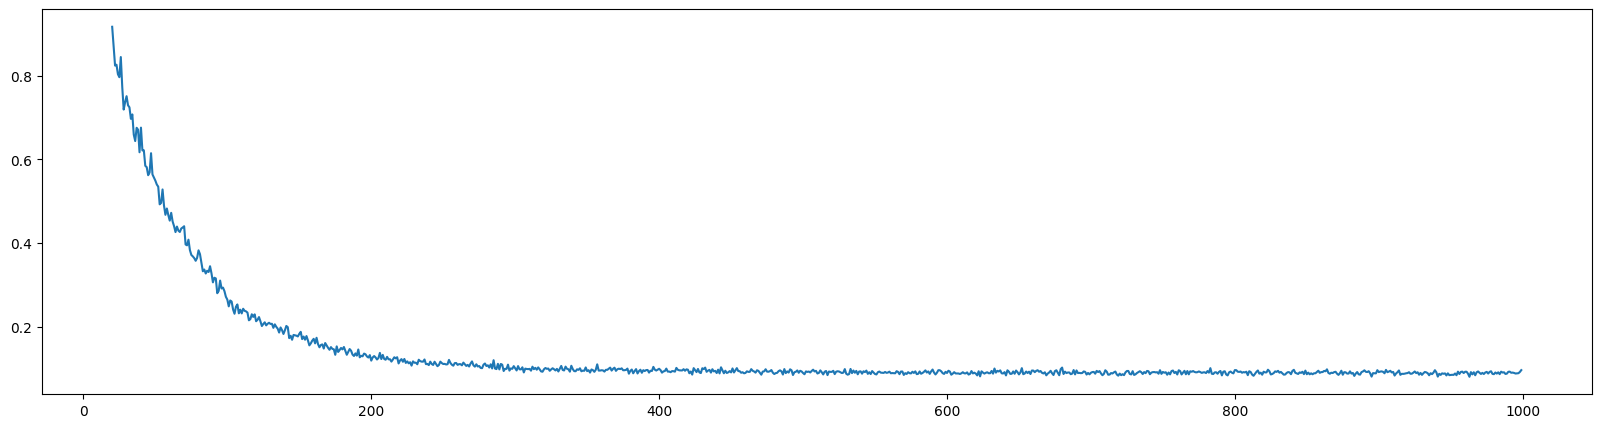

In [64]:
plt.figure(figsize=(20, 5))
plt.plot(df_loss.loc[20: , 'epoch'], df_loss.loc[20: , 'loss'])
plt.show()

In [65]:
test_result = pd.DataFrame(columns=['pred', 'pred_rescale', 'real'])
num = 0
min = scale_params.loc['min', 'kospi']
max = scale_params.loc['max', 'kospi']
with torch.no_grad():
    for _, data in enumerate(test_dataloader):
        inputs = data[0].to(device).float()
        # outputs = data[1].to(device).float()
        outputs = data[1]

        pred = model(inputs)
        for i in range(len(pred)):
            pred_ = pred.detach().cpu().numpy()[i][0]
            pred_scaled = pred_ * (max - min) + min
            out_scaled = outputs.numpy()[i] * (max - min) + min
            # print(out_scaled)
            test_result.loc[num] = [pred_, pred_scaled, out_scaled[0]]
            num += 1

In [66]:
test_result

,pred,pred_rescale,real
0,0.637003,2366.636769,2403.760010
1,0.600533,2272.341070,2433.250000
2,0.652647,2407.088092,2486.669922
3,0.676171,2467.911410,2488.179932
4,0.720344,2582.125080,2469.850098
...,...,...,...
135,0.842428,2897.789809,2742.139893
136,0.691039,2506.355386,2724.179932
137,0.739331,2631.218092,2723.459961
138,0.818687,2836.403048,2721.810059


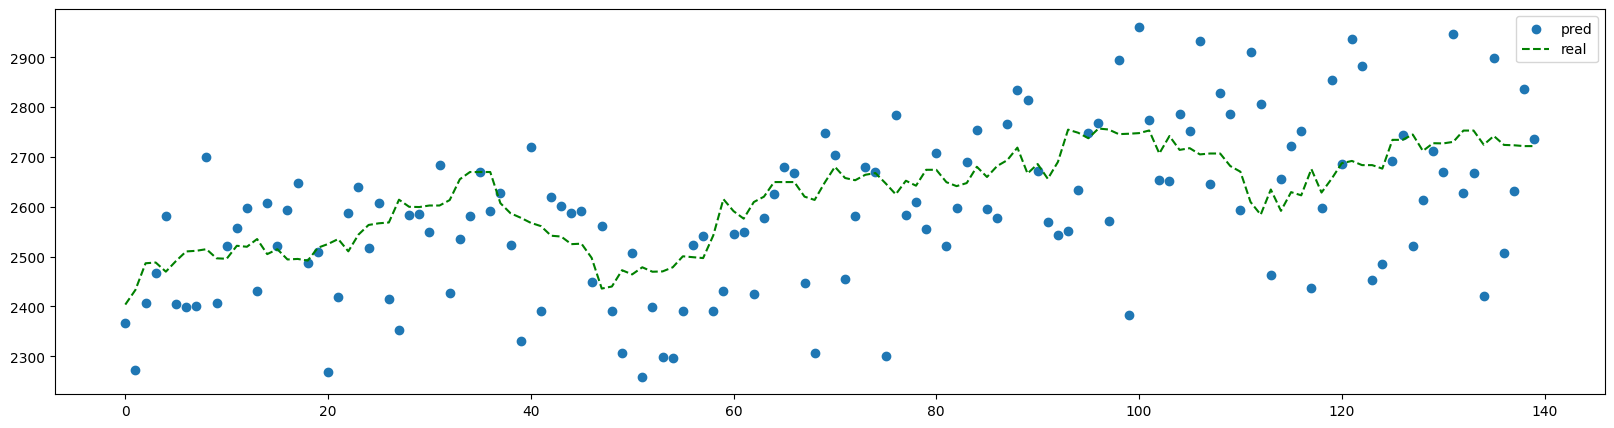

In [67]:
plt.figure(figsize=(20, 5))
# plt.plot(idx_num, test_result['pred'], label='pred')
# plt.plot(range(len(test_result)), test_result['pred_rescale'], label='pred')
plt.scatter(range(len(test_result)), test_result['pred_rescale'], label='pred')
plt.plot(range(len(test_result)), test_result['real'], 'g--', label='real')
plt.legend()
plt.show()

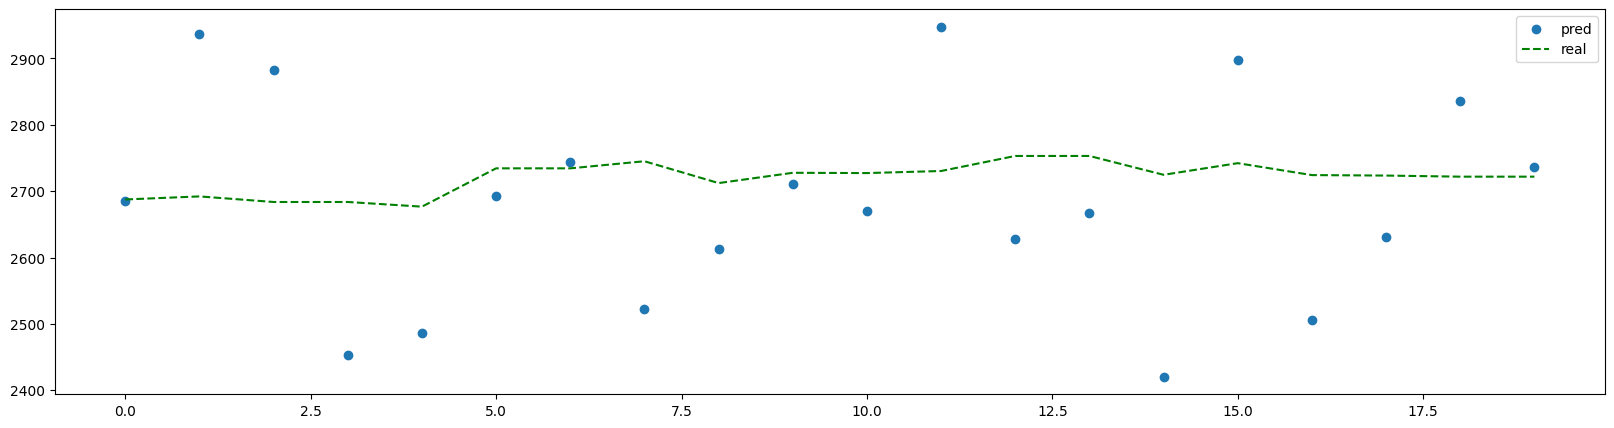

In [68]:
plt.figure(figsize=(20, 5))
# plt.plot(idx_num, test_result['pred'], label='pred')
plt.scatter(range(20), test_result.iloc[-20: , 1], label='pred')
plt.plot(range(20), test_result.iloc[-20: , 2], 'g--', label='real')
# plt.scatter(range(len(test_result)), test_result['pred'], label='pred')
# plt.plot(range(len(test_result)), test_result['real'], 'g--', label='real')
plt.legend()
plt.show()

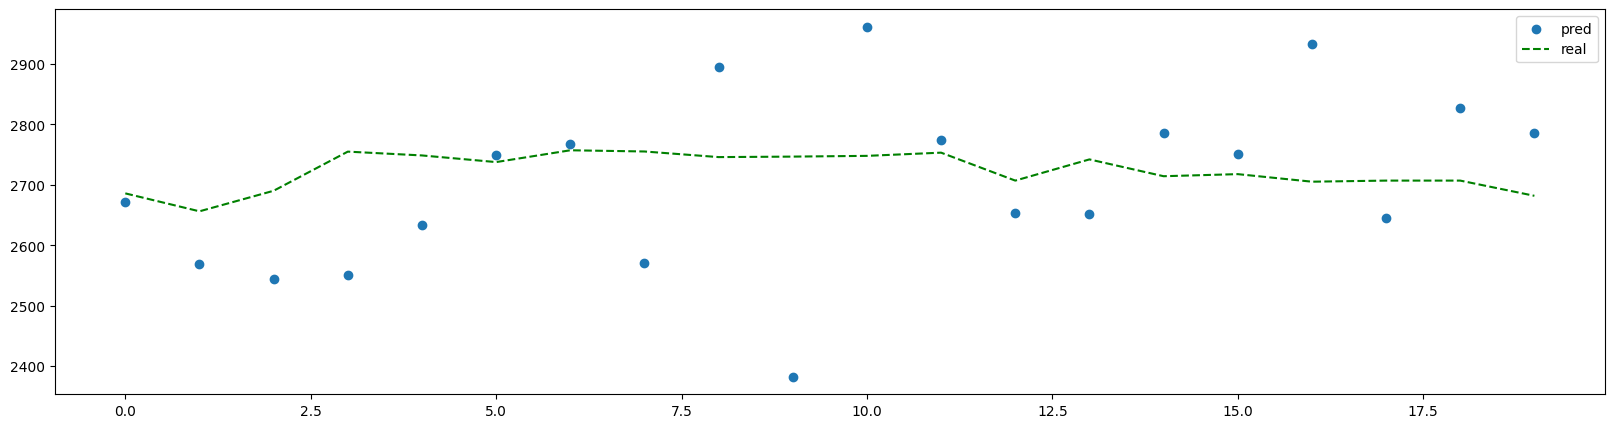

In [69]:
plt.figure(figsize=(20, 5))
# plt.plot(idx_num, test_result['pred'], label='pred')
plt.scatter(range(20), test_result.iloc[-50:-30 , 1], label='pred')
plt.plot(range(20), test_result.iloc[-50:-30 , 2], 'g--', label='real')
# plt.scatter(range(len(test_result)), test_result['pred'], label='pred')
# plt.plot(range(len(test_result)), test_result['real'], 'g--', label='real')
plt.legend()
plt.show()

In [70]:
df_ma = test_result.copy()
df_ma['sma_pred_5d'] = df_ma['pred_rescale'].rolling(5).mean()
df_ma['sma_pred_10d'] = df_ma['pred_rescale'].rolling(10).mean()
df_ma['sma_pred_20d'] = df_ma['pred_rescale'].ewm(20).mean()
df_ma['sma_real_5d'] = df_ma['real'].rolling(5).mean()
df_ma['sma_real_10d'] = df_ma['real'].rolling(10).mean()
df_ma['sma_real_20d'] = df_ma['real'].rolling(20).mean()
df_ma['ewm_pred_5d'] = df_ma['pred_rescale'].ewm(5).mean()
df_ma['ewm_pred_10d'] = df_ma['pred_rescale'].ewm(10).mean()
df_ma['ewm_pred_20d'] = df_ma['pred_rescale'].ewm(20).mean()
df_ma['ewm_real_5d'] = df_ma['real'].ewm(5).mean()
df_ma['ewm_real_10d'] = df_ma['real'].ewm(10).mean()
df_ma['ewm_real_20d'] = df_ma['real'].ewm(20).mean()
df_ma = df_ma.dropna()
df_ma

,pred,pred_rescale,real,sma_pred_5d,sma_pred_10d,sma_pred_20d,sma_real_5d,sma_real_10d,sma_real_20d,ewm_pred_5d,ewm_pred_10d,ewm_pred_20d,ewm_real_5d,ewm_real_10d,ewm_real_20d
19,0.692483,2510.086817,2517.850098,2552.389154,2547.470251,2509.580728,2502.906006,2509.206006,2494.933984,2534.677791,2521.316675,2509.580728,2505.111024,2502.397007,2499.423257
20,0.598734,2267.689572,2525.360107,2501.569808,2522.144078,2491.612567,2504.988037,2512.176025,2501.013989,2489.191022,2494.657149,2491.612567,2508.560859,2504.810729,2501.349898
21,0.656992,2418.322148,2535.270020,2466.522218,2508.175407,2486.309796,2513.186035,2513.527026,2506.114990,2477.161644,2486.745715,2486.309796,2513.094508,2507.967559,2503.804116
22,0.722356,2587.329080,2510.659912,2454.265547,2507.246941,2493.442413,2516.242041,2512.612012,2507.314490,2495.804293,2497.039217,2493.442413,2512.682523,2508.243089,2504.288180
23,0.742328,2638.967917,2544.179932,2484.479107,2528.116218,2503.486570,2526.664014,2513.501001,2510.114490,2519.968866,2511.399792,2503.486570,2517.998967,2511.879237,2507.041505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,0.842428,2897.789809,2742.139893,2711.960983,2682.056378,2680.707275,2740.620020,2734.948999,2704.550000,2687.849666,2686.531490,2680.707275,2727.711889,2713.083505,2697.110942
136,0.691039,2506.355386,2724.179932,2623.706375,2658.258347,2672.394410,2739.387988,2733.930981,2709.607996,2657.600619,2670.151809,2672.394410,2727.123229,2714.092274,2698.401555
137,0.739331,2631.218092,2723.459961,2624.502717,2669.168669,2670.431295,2733.479980,2731.771973,2711.993494,2653.203531,2666.612373,2670.431295,2726.512685,2714.943883,2699.596235
138,0.818687,2836.403048,2721.810059,2658.416269,2691.462692,2678.343686,2727.241992,2732.738989,2716.652991,2683.736784,2682.047916,2678.343686,2725.728914,2715.568082,2700.655237


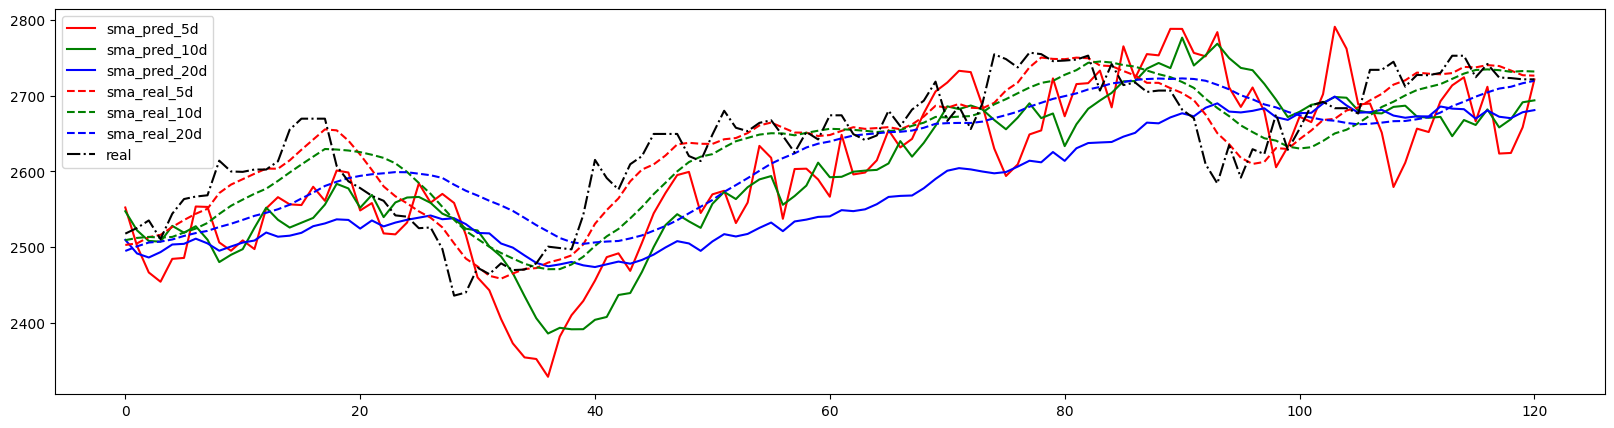

In [71]:
plt.figure(figsize=(20, 5))
plt.plot(range(len(df_ma)), df_ma['sma_pred_5d'], 'r-', label='sma_pred_5d')
plt.plot(range(len(df_ma)), df_ma['sma_pred_10d'], 'g-', label='sma_pred_10d')
plt.plot(range(len(df_ma)), df_ma['sma_pred_20d'], 'b-', label='sma_pred_20d')
plt.plot(range(len(df_ma)), df_ma['sma_real_5d'], 'r--', label='sma_real_5d')
plt.plot(range(len(df_ma)), df_ma['sma_real_10d'], 'g--', label='sma_real_10d')
plt.plot(range(len(df_ma)), df_ma['sma_real_20d'], 'b--', label='sma_real_20d')
plt.plot(range(len(df_ma)), df_ma['real'], 'k-.', label='real')
plt.legend()
plt.show()

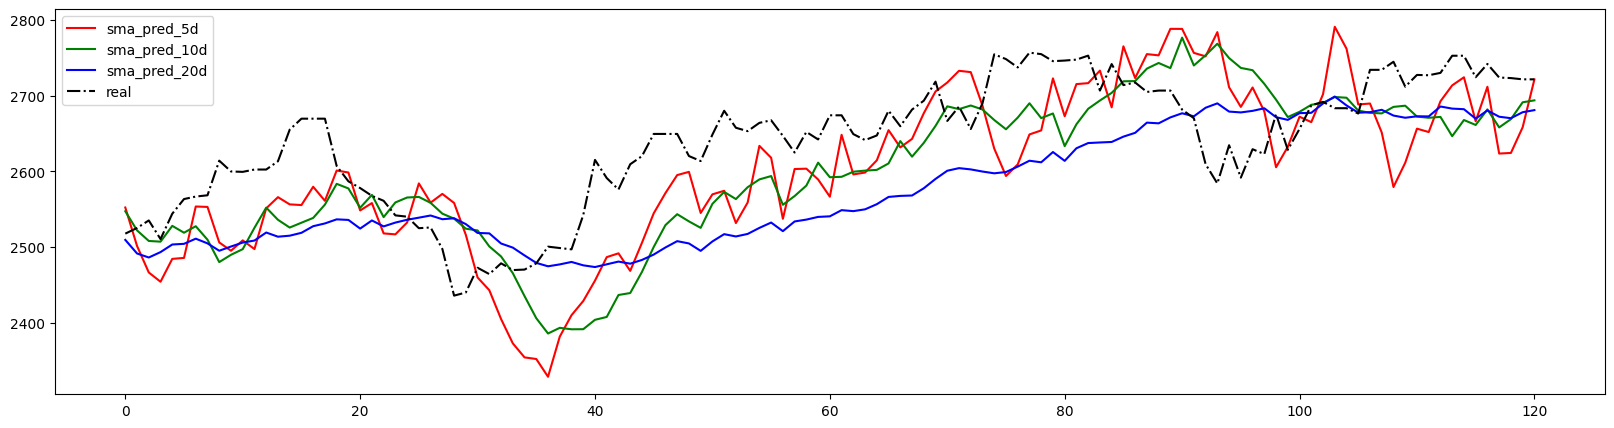

In [72]:
plt.figure(figsize=(20, 5))
plt.plot(range(len(df_ma)), df_ma['sma_pred_5d'], 'r-', label='sma_pred_5d')
plt.plot(range(len(df_ma)), df_ma['sma_pred_10d'], 'g-', label='sma_pred_10d')
plt.plot(range(len(df_ma)), df_ma['sma_pred_20d'], 'b-', label='sma_pred_20d')
# plt.plot(range(len(df_ma)), df_ma['sma_real_5d'], 'r--', label='sma_real_5d')
# plt.plot(range(len(df_ma)), df_ma['sma_real_10d'], 'g--', label='sma_real_10d')
# plt.plot(range(len(df_ma)), df_ma['sma_real_20d'], 'b--', label='sma_real_20d')
plt.plot(range(len(df_ma)), df_ma['real'], 'k-.', label='real')
plt.legend()
plt.show()

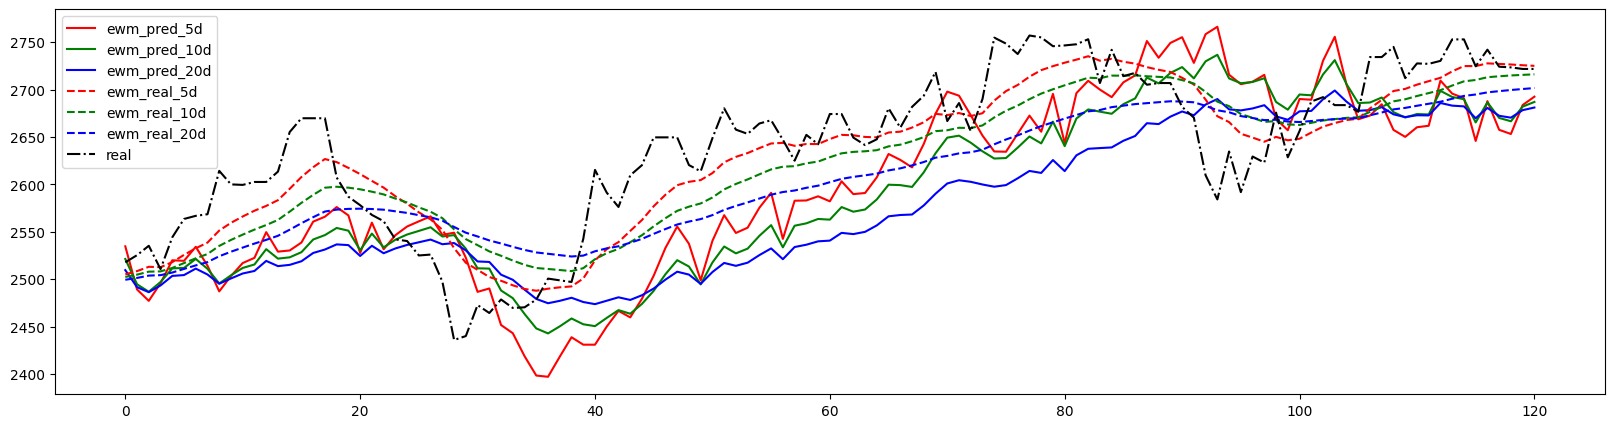

In [73]:
plt.figure(figsize=(20, 5))
plt.plot(range(len(df_ma)), df_ma['ewm_pred_5d'], 'r-', label='ewm_pred_5d')
plt.plot(range(len(df_ma)), df_ma['ewm_pred_10d'], 'g-', label='ewm_pred_10d')
plt.plot(range(len(df_ma)), df_ma['ewm_pred_20d'], 'b-', label='ewm_pred_20d')
plt.plot(range(len(df_ma)), df_ma['ewm_real_5d'], 'r--', label='ewm_real_5d')
plt.plot(range(len(df_ma)), df_ma['ewm_real_10d'], 'g--', label='ewm_real_10d')
plt.plot(range(len(df_ma)), df_ma['ewm_real_20d'], 'b--', label='ewm_real_20d')
plt.plot(range(len(df_ma)), df_ma['real'], 'k-.', label='real')
plt.legend()
plt.show()

## 11. evaluation metrics
MAPE, MSE

In [74]:
mse = mean_squared_error(test_result['real'], test_result['pred_rescale'])
mape = mean_absolute_percentage_error(test_result['real'], test_result['pred_rescale'])
print(f'MSE: {mse:.4f}, MAPE: {mape:.4f}')

MSE: 17991.6641, MAPE: 0.0411
